# Task 1: Genes
### Alina, Lisa, Ömer and Nikolai

## Import Data

In [1]:
# Load libraries
import os
import warnings
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from tqdm import tqdm

In [2]:
# Configure libraries
warnings.filterwarnings("ignore")

In [3]:
# Set location of data directory
data_path = os.path.join("..","Data-PR-As2","Genes")

In [4]:
# Load dataset (this takes a while)
df = pd.read_csv(os.path.join(data_path, "data.csv"))
df_labels = pd.read_csv(os.path.join(data_path, "labels.csv"))

In [5]:
# Remove first columns as they just contain row names
df = df.iloc[:, 1:]
df_labels = df_labels.iloc[:, 1:]

## Data Analysis

In [6]:
# Dimensions of data
n_observations, n_features = df.shape
print("# observations:",n_observations," # features:", n_features)
classes = df_labels["Class"].unique()
n_classes = len(classes)
print("There are", n_classes, "classes:", classes)

# observations: 801  # features: 20531
There are 5 classes: ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']


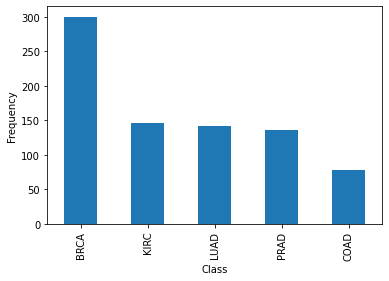

In [7]:
# Inspect frequency of class labels
ax = df_labels.apply(pd.value_counts).plot(kind='bar', legend=False)
# ax.bar_label(ax.containers[0])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

There are 3 times more examples of BRCA than COAD. We therefore have a somewhat unbalanced dataset.

Min value: 0.0  Max value: 20.7788287118


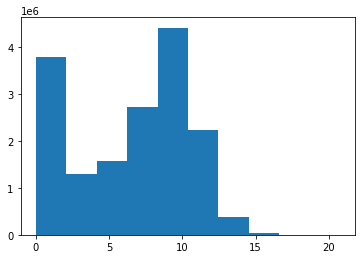

In [8]:
# Distribution of data across all features
df.stack().hist(grid=False)
df_np = df.to_numpy()
print("Min value:", df_np.min(), " Max value:", df_np.max())

In [9]:
# mean, std, min and max values vary between genes
df.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


In [10]:
# Check dataframe for duplicate rows.
print(any(df.duplicated()))

False


In [11]:
def plot_tsne(x, y):
    tsne = TSNE(n_components=2, random_state=0)
    X_tsne = tsne.fit_transform(x)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y.to_numpy().flatten(), 
                    palette=sns.color_palette(n_colors=n_classes), data=y)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

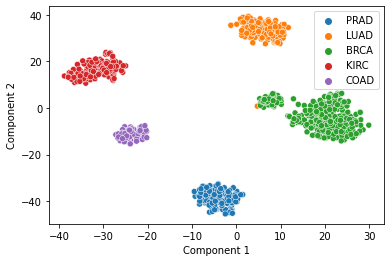

In [12]:
# Visualize multidimensional data
plot_tsne(df, df_labels)

## Feature Selection / Dimension Reduction

### PCA

In [13]:
def best_pca(components, x_train, y_train, x_test, y_test, model, normalizer=None):
    scores = []
    for n in tqdm(components):
        pca = PCA(n_components=n)
        x_train_norm, x_test_norm = (x_train, x_test)
        X_train_pca = pca.fit_transform(x_train_norm)
        x_test_pca = pca.transform(x_test_norm)
        model = SVC()
        y_pred = model.fit(X_train_pca, y_train).predict(x_test_pca)
        scores.append(accuracy_score(y_test, y_pred))
    return scores

100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.01it/s]


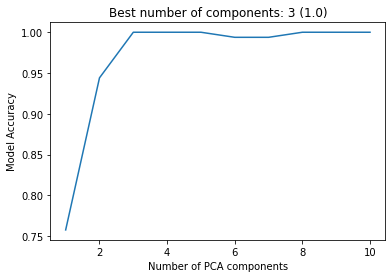

In [14]:
max_comp = 10
components = list(range(1, max_comp + 1))
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=0)
scores = best_pca(components, X_train, y_train, X_test, y_test, SVC(), None)
plt.plot(components, scores)
plt.xlabel("Number of PCA components")
plt.ylabel("Model Accuracy")
plt.title("Best number of components: " + str(np.argmax(scores) + 1) + " (" + str(round(max(scores),3)) + ")")
plt.show()

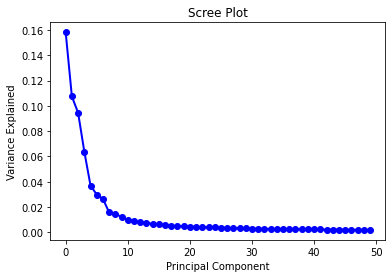

In [15]:
total_components = 50
pca = PCA(n_components=total_components)
pca.fit(X_train)
plt.plot(list(range(total_components)), pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### Mutual Information

In [17]:
# This takes like a minute to run
selector = SelectKBest(mutual_info_classif, k="all")
selector.fit(X_train, y_train)
feature_importance = np.flip(np.argsort(selector.scores_))

In [22]:
def best_mutual_info(top_n_feat, top_features, x_train, y_train, x_test, y_test, model):
    scores = []
    for i in tqdm(range(1, top_n_feat + 1)):
        best_cols = top_features[:i]
        reduced_x_train = X_train.iloc[:,best_cols]
        reduced_x_test = X_test.iloc[:,best_cols]
        y_pred = model.fit(reduced_x_train, y_train).predict(reduced_x_test)
        scores.append(accuracy_score(y_test, y_pred))
    return scores

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 181.41it/s]


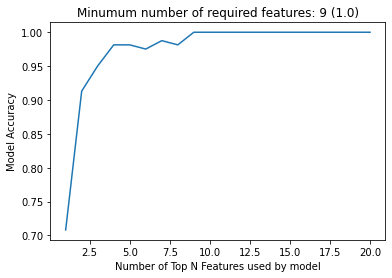

Top 9 genes: [ 5407  5576  6816  7964  7992  8349 17109 18381 18746]


In [23]:
top_n_feat = 20
scores = best_mutual_info(top_n_feat, feature_importance, X_train, y_train, X_test, y_test, SVC())
plt.plot(list(range(1,top_n_feat + 1)), scores)
plt.xlabel("Number of Top N Features used by model")
plt.ylabel("Model Accuracy")
min_feat = np.argmax(scores) + 1
plt.title(f"Minumum number of required features: {min_feat} ({round(max(scores),3)})")
plt.show()
print(f"Top {min_feat} genes: {np.sort(feature_importance[:min_feat])}")

## Classification (K-fold)

In [19]:
def get_train_test(type_: str, X_train, X_test, pca):
    if type_ == "PCA":
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    return X_train, X_test

def cross_val(model, df, df_labels, type_: str):
    pca = PCA(n_components=3)
    pred_times = []
    acc = []

    start_train = time.time()
    kf = StratifiedKFold(n_splits=5)
    for train_index, test_index in kf.split(df, df_labels):
        X_train, X_test = [df.iloc[i] for i in train_index], [df.iloc[i] for i in test_index]
        y_train, y_test = [df_labels.iloc[i] for i in train_index], [df_labels.iloc[i] for i in test_index]
        X_train, X_test = get_train_test(type_, X_train, X_test, pca)
        out = model.fit(X_train, y_train)
        start_pred = time.time()
        y_pred = out.predict(X_test)
        end_pred = time.time()
        pred_times.append(end_pred - start_pred)
        acc.append(accuracy_score(y_test, y_pred))
    end_train = time.time()

    print(f"Model: {model}, with{'out' if type_ != 'PCA' else ''} PCA")
    print("avg training diff:", (end_train - start_train)/5)
    print("avg predicting diff:", sum(pred_times)/5)
    print("avg predicting acc:", sum(acc)/5)
    print("------------------------------------------")

In [20]:
model = SVC()
cross_val(model, df, df_labels, "n")
cross_val(model, df, df_labels, "PCA")

model = GaussianNB()
cross_val(model, df, df_labels, "n")
cross_val(model, df, df_labels, "PCA")

model = KNeighborsClassifier(n_neighbors=3)
cross_val(model, df, df_labels, "n")
cross_val(model, df, df_labels, "PCA")


Model: SVC(), without PCA
avg training diff: 1.9881021499633789
avg predicting diff: 0.985779094696045
avg predicting acc: 0.9962577639751553
------------------------------------------
Model: SVC(), with PCA
avg training diff: 0.7199347972869873
avg predicting diff: 0.0011547565460205077
avg predicting acc: 0.9850155279503106
------------------------------------------
Model: GaussianNB(), without PCA
avg training diff: 0.24093070030212402
avg predicting diff: 0.055579090118408205
avg predicting acc: 0.775170807453416
------------------------------------------
Model: GaussianNB(), with PCA
avg training diff: 0.701262092590332
avg predicting diff: 0.00039124488830566406
avg predicting acc: 0.9800077639751553
------------------------------------------
Model: KNeighborsClassifier(n_neighbors=3), without PCA
avg training diff: 0.3749066352844238
avg predicting diff: 0.24087190628051758
avg predicting acc: 0.9987577639751553
------------------------------------------
Model: KNeighborsClassif